In [1]:
!pip install diffusers

cuda


100%|██████████| 118/118 [02:40<00:00,  1.36s/it]

Epoch 0 | Loss: 0.06337097617087223


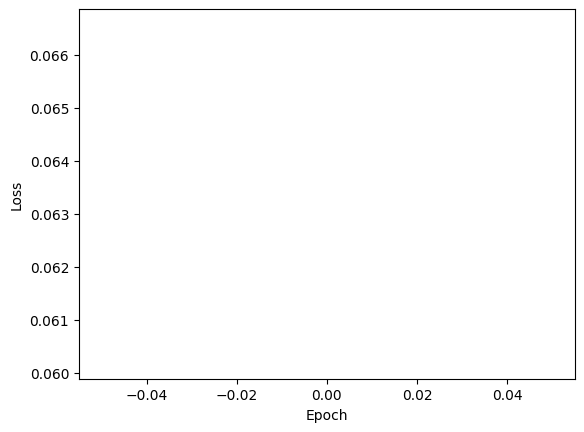

1000it [00:18, 52.74it/s]


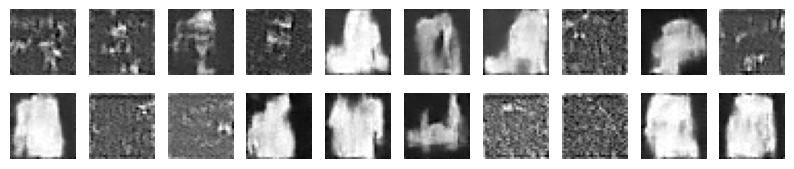

 18%|█▊        | 21/118 [00:28<02:12,  1.37s/it]


KeyboardInterrupt: 

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
from diffusers import UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hyperparameters
img_size = 32
batch_size = 512
max_steps = 1000
lr = 1e-3
epochs = 1000

def prepare_dataset_with_labels(batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    # FashionMNISTデータセットの読み込み
    dataset = datasets.FashionMNIST(root="./data", download=True, transform=transform)

    # クラスラベルのマッピング
    labels = {
        0: "T-shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }

    # DataLoaderの作成
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader, labels

def show_images(images, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
            plt.axis('off')
            i += 1
    plt.show()

def diffusion_process(scheduler, model, text_embeddings):
    samples = torch.randn((20, 1, img_size, img_size), device=device)
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        samples = scheduler.step(model(samples, t, encoder_hidden_states=text_embeddings).sample, t, samples).prev_sample
    return samples

# Select device
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

# Prepare dataset and labels
dataloader, labels = prepare_dataset_with_labels(batch_size)  # Ensure labels are loaded

# Initialize model, CLIP, and scheduler
model = UNet2DConditionModel(
    sample_size=img_size,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 128),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    cross_attention_dim=512  # Match CLIP's embedding size
).to(device)

# Scheduler for Diffusion
scheduler = DDPMScheduler(num_train_timesteps=max_steps)

# CLIP components
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)

# Define prompt generation function
def generate_prompts(label):
    return [
        f"This is a {label}",
        f"A {label} is shown here",
        f"Picture of a {label}",
        f"An example of a {label}",
        f"Visual representation of a {label}",
        f"Here is a {label}",
        f"Generated image of a {label}",
        f"This looks like a {label}",
        f"Digital version of a {label}",
        f"A drawing of a {label}",
    ]

# Training loop
losses = []
for epoch in range(epochs):
    model.train()
    loss_sum = 0.0
    cnt = 0
    for images, lbls in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        t = torch.randint(0, max_steps, (len(x),), device=device)  # Randam time step
        noise = torch.randn_like(x)                                # Generate random noise
        noisy_images = scheduler.add_noise(x, noise, t)            # Add noise to images

        # ラベルテンソルからプロンプトを生成
        prompts = [labels[lbl.item()] for lbl in lbls]

        # テキスト埋め込みの取得
        tokens = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(device)
        text_embeddings = text_encoder(**tokens).last_hidden_state

        # Predict noise using cross-attention
        noise_pred = model(noisy_images, t, encoder_hidden_states=text_embeddings).sample

        # Diffusion
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

    # Save model checkpoint
    checkpoint_path = f"data/FashionMNIST/checkpoint_epoch_{epoch}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_avg,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

    # Plot losses
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Generate and visualize samples with last batch
    model.eval()
    with torch.no_grad():
        samples = diffusion_process(scheduler, model, text_embeddings[:20]).to('cpu')

    show_images([sample[0] for sample in samples])

# Save model
model.save_pretrained("data/FashionMNIST/")


1000it [00:17, 56.52it/s]


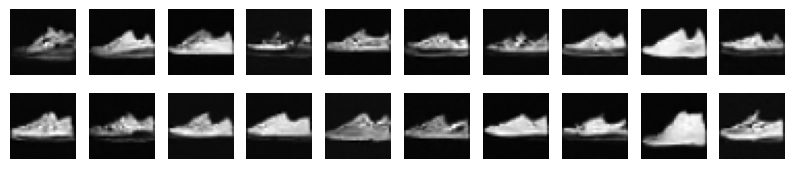

1000it [00:18, 53.88it/s]


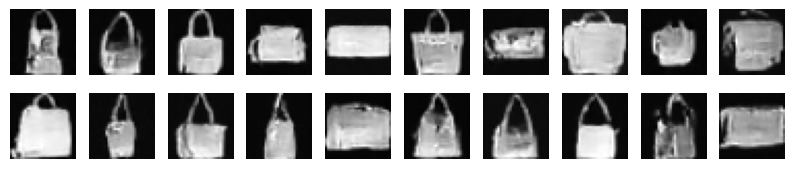

1000it [00:17, 56.15it/s]


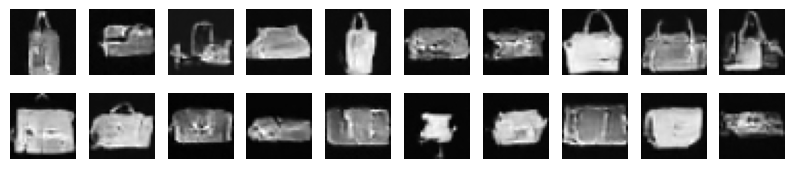

In [ ]:
    # Generate and visualize samples
    def generate_image(prompt):
        model.eval()
        with torch.no_grad():
            prompts = [prompt] * 20
            # テキスト埋め込みの取得
            tokens = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(device)
            text_embeddings = text_encoder(**tokens).last_hidden_state
            samples = torch.randn((20, 1, img_size, img_size), device=device)
            for i, t in tqdm(enumerate(scheduler.timesteps)):
                samples = scheduler.step(model(samples, t, encoder_hidden_states=text_embeddings).sample, t, samples).prev_sample

        show_images([sample[0] for sample in samples.to('cpu')])

generate_image("This is a Sneaker")
generate_image("This is a Bag")
generate_image("This is a Bag-shaped Sneaker")



In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
from diffusers import UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hyperparameters
img_size = 32
batch_size = 512
max_steps = 1000
lr = 1e-3
epochs = 1000

# Device selection
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Dataset and labels
def prepare_dataset(batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    dataset = datasets.FashionMNIST(root="./data", download=True, transform=transform)
    labels = {
        0: "T-shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
        5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
    }
    return DataLoader(dataset, batch_size=batch_size, shuffle=True), labels

# Visualize images
def show_images(images, rows=2, cols=10):
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Diffusion process
def diffusion_process(scheduler, model, text_embeddings):
    samples = torch.randn((20, 1, img_size, img_size), device=device)
    for t in tqdm(scheduler.timesteps):
        samples = scheduler.step(
            model(samples, t, encoder_hidden_states=text_embeddings[:20]).sample, t, samples
        ).prev_sample
    return samples

# Save checkpoint
def save_checkpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Checkpoint saved at {path}")

# Main training loop
def train_model():
    # Data Loader
    dataloader, labels = prepare_dataset(batch_size)

    # Model
    model = UNet2DConditionModel(
        sample_size=img_size, in_channels=1, out_channels=1, layers_per_block=2,
        block_out_channels=(32, 64, 128),
        down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
        up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
        cross_attention_dim=512
    ).to(device)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=lr)

    # Scheduler, Tokenizer, TextEncoder setup
    scheduler = DDPMScheduler(num_train_timesteps=max_steps)
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

    losses = []
    # training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        # minibatch loop
        for images, lbls in tqdm(dataloader):
            optimizer.zero_grad()
            x = images.to(device)

            t = torch.randint(0, max_steps, (len(x),), device=device) # timestep
            noise = torch.randn_like(x)                               # Make noise
            noisy_images = scheduler.add_noise(x, noise, t)           # Add noise

            prompts = [labels[lbl.item()] for lbl in lbls]            # label index to prompt
            tokens = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(device)
            text_embeddings = text_encoder(**tokens).last_hidden_state # Text Embedding

            # Diffusion Process
            noise_pred = model(noisy_images, t, encoder_hidden_states=text_embeddings).sample

            # Back Propagation
            loss = F.mse_loss(noise_pred, noise)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Calculate Loss
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch} | Loss: {avg_loss}")

        # Save checkpoint model
        checkpoint_path = f"data/FashionMNIST/checkpoint_epoch_{epoch}.pth"
        save_checkpoint(model, optimizer, epoch, avg_loss, checkpoint_path)

        # Plot Losses
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        # Validate current diffusion model result
        model.eval()
        with torch.no_grad():
            samples = diffusion_process(scheduler, model, text_embeddings).to('cpu')
        show_images([sample[0] for sample in samples])

    # Save model
    model.save_pretrained("data/FashionMNIST/")

if __name__ == "__main__":
    train_model()


Using device: cpu


  0%|          | 0/118 [00:00<?, ?it/s]

In [ ]:
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from diffusers import UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hyperparameters
img_size = 32
batch_size = 512
max_steps = 1000
lr = 1e-3
epochs = 1000

# Device selection
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Dataset and labels
def prepare_dataset(batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    dataset = datasets.FashionMNIST(root="./data", download=True, transform=transform)
    labels = {
        0: "T-shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
        5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
    }
    return DataLoader(dataset, batch_size=batch_size, shuffle=True), labels

# Visualize images
def show_images(images, rows=2, cols=10):
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Diffusion process
def diffusion_process(scheduler, model, text_embeddings):
    samples = torch.randn((20, 1, img_size, img_size), device=device)
    for t in tqdm(scheduler.timesteps):
        samples = scheduler.step(
            model(samples, t, encoder_hidden_states=text_embeddings[:20]).sample, t, samples
        ).prev_sample
    return samples

# Save checkpoint
def save_checkpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Checkpoint saved at {path}")

# Main training loop
def train_model():
    # Data Loader
    dataloader, labels = prepare_dataset(batch_size)

    # Model
    model = UNet2DConditionModel(
        sample_size=img_size, in_channels=1, out_channels=1, layers_per_block=2,
        block_out_channels=(32, 64, 128),
        down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
        up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
        cross_attention_dim=512
    ).to(device)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=lr)

    # Scheduler, Tokenizer, TextEncoder setup
    scheduler = DDPMScheduler(num_train_timesteps=max_steps)
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

    losses = []
    # training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        # minibatch loop
        for images, lbls in tqdm(dataloader):
            optimizer.zero_grad()
            x = images.to(device)

            t = torch.randint(0, max_steps, (len(x),), device=device) # timestep
            noise = torch.randn_like(x)                               # Make noise
            noisy_images = scheduler.add_noise(x, noise, t)           # Add noise

            prompts = [labels[lbl.item()] for lbl in lbls]            # label index to prompt
            tokens = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(device)
            text_embeddings = text_encoder(**tokens).last_hidden_state # Text Embedding

            # Diffusion Process
            noise_pred = model(noisy_images, t, encoder_hidden_states=text_embeddings).sample

            # Back Propagation
            loss = F.mse_loss(noise_pred, noise)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Calculate Loss
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch} | Loss: {avg_loss}")

        # Save checkpoint model
        checkpoint_path = f"data/FashionMNIST/checkpoint_epoch_{epoch}.pth"
        save_checkpoint(model, optimizer, epoch, avg_loss, checkpoint_path)

        # Plot Losses
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        # Validate current diffusion model result
        model.eval()
        with torch.no_grad():
            samples = diffusion_process(scheduler, model, text_embeddings).to('cpu')
        show_images([sample[0] for sample in samples])

    # Save model
    model.save_pretrained("data/FashionMNIST/")

if __name__ == "__main__":
    train_model()


Using device: cpu


100%|██████████| 118/118 [34:01<00:00, 17.30s/it]


Epoch 0 | Loss: 0.9954595818357953
Checkpoint saved at data/FashionMNIST/checkpoint_epoch_0.pth


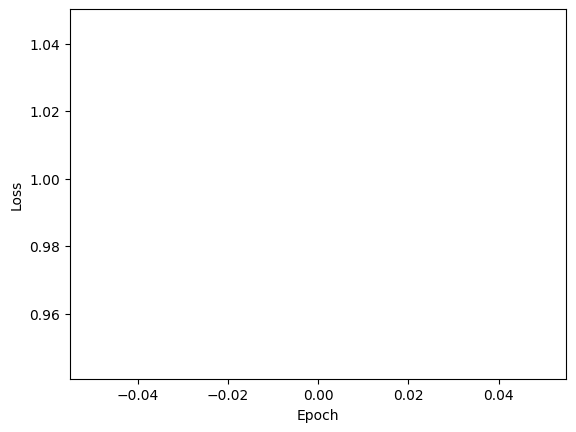

  0%|          | 0/1000 [00:00<?, ?it/s]


AttributeError: 'Tensor' object has no attribute 'sample'

In [5]:
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from diffusers import UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hyperparameters
img_size = 32
batch_size = 512
max_steps = 1000
lr = 1e-3
epochs = 1000

# Device selection
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Dataset and labels
def prepare_dataset(batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    dataset = datasets.FashionMNIST(root="./data", download=True, transform=transform)
    labels = {
        0: "T-shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
        5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
    }
    return DataLoader(dataset, batch_size=batch_size, shuffle=True), labels

# Visualize images
def show_images(images, rows=2, cols=10):
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Diffusion process
def diffusion_process(scheduler, model, text_embeddings):
    samples = torch.randn((20, 1, img_size, img_size), device=device)
    for t in tqdm(scheduler.timesteps):
        samples = scheduler.step(
            model(samples, t, encoder_hidden_states=text_embeddings[:20]).sample, t, samples
        ).prev_sample
    return samples

# Save checkpoint
def save_checkpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Checkpoint saved at {path}")

# Custom DDPM Scheduler
class CustomDDPMScheduler:
    def __init__(self, num_train_timesteps):
        self.num_train_timesteps = num_train_timesteps
        self.timesteps = torch.arange(num_train_timesteps).flip(0)
        self.betas = torch.linspace(0.0001, 0.02, num_train_timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, original_images, noise, t):
        sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod[t])
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod[t])
        return sqrt_alphas_cumprod[:, None, None, None] * original_images + \
               sqrt_one_minus_alphas_cumprod[:, None, None, None] * noise

    def step(self, model_output, t, sample):
        alpha_t = self.alphas[t]
        beta_t = self.betas[t]
        alpha_cumprod_t = self.alphas_cumprod[t]
        alpha_cumprod_t_prev = self.alphas_cumprod[t - 1] if t > 0 else 1.0

        pred_sample = (sample - torch.sqrt(1 - alpha_cumprod_t) * model_output) / torch.sqrt(alpha_cumprod_t)
        pred_prev_sample = torch.sqrt(alpha_cumprod_t_prev) * pred_sample + \
                           torch.sqrt(1 - alpha_cumprod_t_prev) * model_output

        return type("StepResult", (), {"prev_sample": pred_prev_sample})()

class CrossAttention(torch.nn.Module):
    def __init__(self, hidden_dim, encoder_hidden_dim):
        super().__init__()
        self.query = torch.nn.Linear(hidden_dim, hidden_dim)
        self.key = torch.nn.Linear(encoder_hidden_dim, hidden_dim)
        self.value = torch.nn.Linear(encoder_hidden_dim, hidden_dim)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x, encoder_hidden_states):
        batch_size, channels, height, width = x.size()
        x_flat = x.view(batch_size, channels, -1).permute(0, 2, 1)  # B x HW x C

        query = self.query(x_flat)  # B x HW x C
        key = self.key(encoder_hidden_states).permute(0, 2, 1)  # B x C x SeqLen
        value = self.value(encoder_hidden_states)  # B x SeqLen x C

        attention_scores = torch.bmm(query, key) / (channels ** 0.5)  # B x HW x SeqLen
        attention_probs = self.softmax(attention_scores)
        attended_values = torch.bmm(attention_probs, value)  # B x HW x C

        attended_values = attended_values.permute(0, 2, 1).view(batch_size, channels, height, width)  # B x C x H x W
        return attended_values

# Custom UNet implementation
class CustomUNet(torch.nn.Module):
    def __init__(self, img_size, in_channels, out_channels, layers_per_block, block_out_channels):
        super().__init__()
        self.encoder = self.build_encoder(in_channels, block_out_channels, layers_per_block)
        self.middle = CrossAttention(block_out_channels[-1], encoder_hidden_dim=512)
        self.decoder = self.build_decoder(out_channels, block_out_channels, layers_per_block)

    def build_encoder(self, in_channels, block_out_channels, layers_per_block):
        layers = []
        prev_channels = in_channels
        for channels in block_out_channels:
            for _ in range(layers_per_block):
                layers.append(torch.nn.Conv2d(prev_channels, channels, kernel_size=3, padding=1))
                layers.append(torch.nn.ReLU())
                prev_channels = channels
            layers.append(torch.nn.MaxPool2d(kernel_size=2))
        return torch.nn.Sequential(*layers)

    def build_decoder(self, out_channels, block_out_channels, layers_per_block):
        layers = []
        prev_channels = block_out_channels[-1]
        for channels in reversed(block_out_channels):
            layers.append(torch.nn.ConvTranspose2d(prev_channels, channels, kernel_size=2, stride=2))
            for _ in range(layers_per_block):
                layers.append(torch.nn.Conv2d(channels, channels, kernel_size=3, padding=1))
                layers.append(torch.nn.ReLU())
            prev_channels = channels
        layers.append(torch.nn.Conv2d(prev_channels, out_channels, kernel_size=3, padding=1))
        return torch.nn.Sequential(*layers)

    def forward(self, x, t, encoder_hidden_states):
        x = self.encoder(x)
        x = self.middle(x, encoder_hidden_states)
        x = self.decoder(x)
        return x

# Main training loop
def train_model():
    # Data Loader
    dataloader, labels = prepare_dataset(batch_size)

    # Model
    #model = UNet2DConditionModel(
    #    sample_size=img_size, in_channels=1, out_channels=1, layers_per_block=2,
    #    block_out_channels=(32, 64, 128),
    #    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    #    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    #    cross_attention_dim=512
    #).to(device)

    model = CustomUNet(
        img_size=img_size, in_channels=1, out_channels=1, layers_per_block=2,
        block_out_channels=(32, 64, 128)
    ).to(device)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=lr)

    # Scheduler, Tokenizer, TextEncoder setup
    # scheduler = DDPMScheduler(num_train_timesteps=max_steps)
    scheduler = CustomDDPMScheduler(num_train_timesteps=max_steps)

    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

    losses = []
    # training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        # minibatch loop
        for images, lbls in tqdm(dataloader):
            optimizer.zero_grad()
            x = images.to(device)

            t = torch.randint(0, max_steps, (len(x),), device=device) # timestep
            noise = torch.randn_like(x)                               # Make noise
            noisy_images = scheduler.add_noise(x, noise, t)           # Add noise

            prompts = [labels[lbl.item()] for lbl in lbls]            # label index to prompt
            tokens = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(device)
            text_embeddings = text_encoder(**tokens).last_hidden_state # Text Embedding

            # Diffusion Process
            noise_pred = model(noisy_images, t, encoder_hidden_states=text_embeddings)

            # Back Propagation
            loss = F.mse_loss(noise_pred, noise)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Calculate Loss
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch} | Loss: {avg_loss}")

        # Save checkpoint model
        checkpoint_path = f"data/FashionMNIST/checkpoint_epoch_{epoch}.pth"
        save_checkpoint(model, optimizer, epoch, avg_loss, checkpoint_path)

        # Plot Losses
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        # Validate current diffusion model result
        model.eval()
        with torch.no_grad():
            samples = diffusion_process(scheduler, model, text_embeddings).to('cpu')
        show_images([sample[0] for sample in samples])

    # Save model
    model.save_pretrained("data/FashionMNIST/")

if __name__ == "__main__":
    train_model()
